# Overview Solution Workflow
There are 7 stages to complete when approaching an ML problem
1. Question / Problem definition
2. Acquire training and testing data
3. Wrangle, prepare and cleanse data
4. Analyze, identify patterns and explore the data
5. Model, predict and solve the problem.
6 Visualize,  report and present the problem solving steps and final solution
7. Supply or submit the results



# Stage 1: Question / Problem Definition

The objective of this project would be to predict sales for the thousands of product families sold at Favorita stores located in Ecuador. The data used includes dates, store and product information, whether that item was being promoted, as well as the sales numbers. Additional files include supplementary information that may be useful in building your models.

#Stage 2: Acquire training and testing data
There are 6 .csv files provided:

1. train.csv, which includes:
    - store_nbr
    - family
    - onpromotion
    - (target) sales

2. test.csv, which includes the same features as the training data

3. sample_submission.csv, which is a sample submission file in the correct format

4. stores.csv, which includes:
    - Store metadata, including city, state, type, and cluster.
        - Cluster is a grouping of similar stores.

5. oil.csv

    - Daily oil price. Includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)

6. holidays_events.csv

    - Holidays and Events, with metadata
    NOTE: Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.
    Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).

Additional Notes

    Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. Supermarket sales could be affected by this.
    A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly 

# Initializing the required libraries and Analyzing the data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import gc

In [2]:
training_data = pd.read_csv('store_sales_data/train.csv')
test_data = pd.read_csv('store_sales_data/test.csv')
stores_data = pd.read_csv('store_sales_data/stores.csv')
holiday_events_data = pd.read_csv('store_sales_data/holidays_events.csv')
transactions_data = pd.read_csv('store_sales_data/transactions.csv')
sample_submission_data = pd.read_csv('store_sales_data/sample_submission.csv')

training_data['date'] = pd.to_datetime(training_data.date)
test_data['date'] = pd.to_datetime(test_data.date)
transactions_data['date'] = pd.to_datetime(transactions_data.date)

training_data.onpromotion = training_data.onpromotion.astype("float16")
training_data.sales = training_data.sales.astype("float16")
stores_data.cluster = stores_data.cluster.astype("int8")

training_data.head()

c:\Users\NicholasTeng\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\dtypes\astype.py:134: RuntimeWarning: overflow encountered in cast
  return arr.astype(dtype, copy=True)


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0.0
1,1,2013-01-01,1,BABY CARE,0.0,0.0
2,2,2013-01-01,1,BEAUTY,0.0,0.0
3,3,2013-01-01,1,BEVERAGES,0.0,0.0
4,4,2013-01-01,1,BOOKS,0.0,0.0


In [3]:
a = transactions_data.copy()
a["year"] = a.date.dt.year
a["month"] = a.date.dt.month
px.box(a, x="year", y="transactions" , color = "month", title = "Transactions")

# Observation
It would seem that there is always a spike in the number of transactions during the December period. This is probably attritubted by the buying of gifts for Christmas.


<Axes: xlabel='transactions', ylabel='sales'>

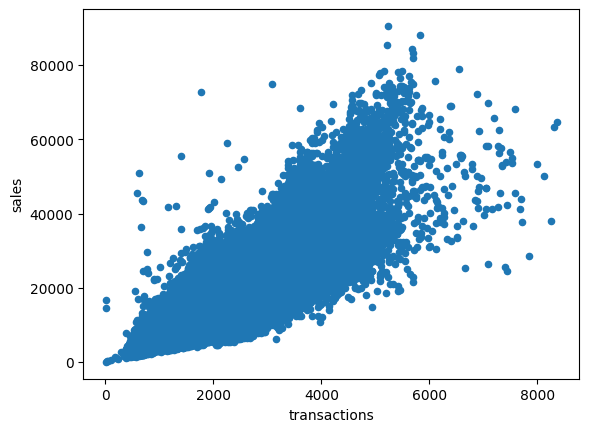

In [4]:
temp = pd.merge(training_data.groupby(["date", "store_nbr"]).sales.sum().reset_index(), transactions_data, how = "left")

temp = pd.DataFrame(temp)

temp.plot(x='transactions',y='sales', kind = 'scatter')





# Observation

From the scatter plot, it is obvious that as the number of transactions increase, so do the sales. This indicates that there is a correlation between the 2.

In [5]:
a = transactions_data.copy()
a["year"] = a.date.dt.year
a["dayofweek"] = a.date.dt.dayofweek+1
a = a.groupby(["year", "dayofweek"]).transactions.mean().reset_index()
px.line(a, x="dayofweek", y="transactions" , color = "year", title = "Transactions")



# Observation

From this graph, Saturday seems to have the highest number of transactions


In [6]:

a = pd.DataFrame(training_data)

a["year"] = a.date.dt.year
a["dayofweek"] = a.date.dt.dayofweek+1

a = a.groupby(["year", "dayofweek"]).sales.mean().reset_index()
px.line(a, x="dayofweek", y="sales" , color = "year", title = "sales")


In [7]:
# Import 
oil = pd.read_csv("store_sales_data/oil.csv")
oil["date"] = pd.to_datetime(oil.date)
# Resample
oil = oil.set_index("date").dcoilwtico.resample("D").sum().reset_index()
# Interpolate
oil["dcoilwtico"] = np.where(oil["dcoilwtico"] == 0, np.nan, oil["dcoilwtico"])
oil["dcoilwtico_interpolated"] =oil.dcoilwtico.interpolate()
# Plot
p = oil.melt(id_vars=['date']+list(oil.keys()[5:]), var_name='Legend')
px.line(p.sort_values(["Legend", "date"], ascending = [False, True]), x='date', y='value', color='Legend',title = "Daily Oil Price" )

c:\Users\NicholasTeng\AppData\Local\Programs\Python\Python311\Lib\site-packages\_plotly_utils\basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



# Observation

In this, I have used linear interpolation to fill up the missing data within the csv file. 

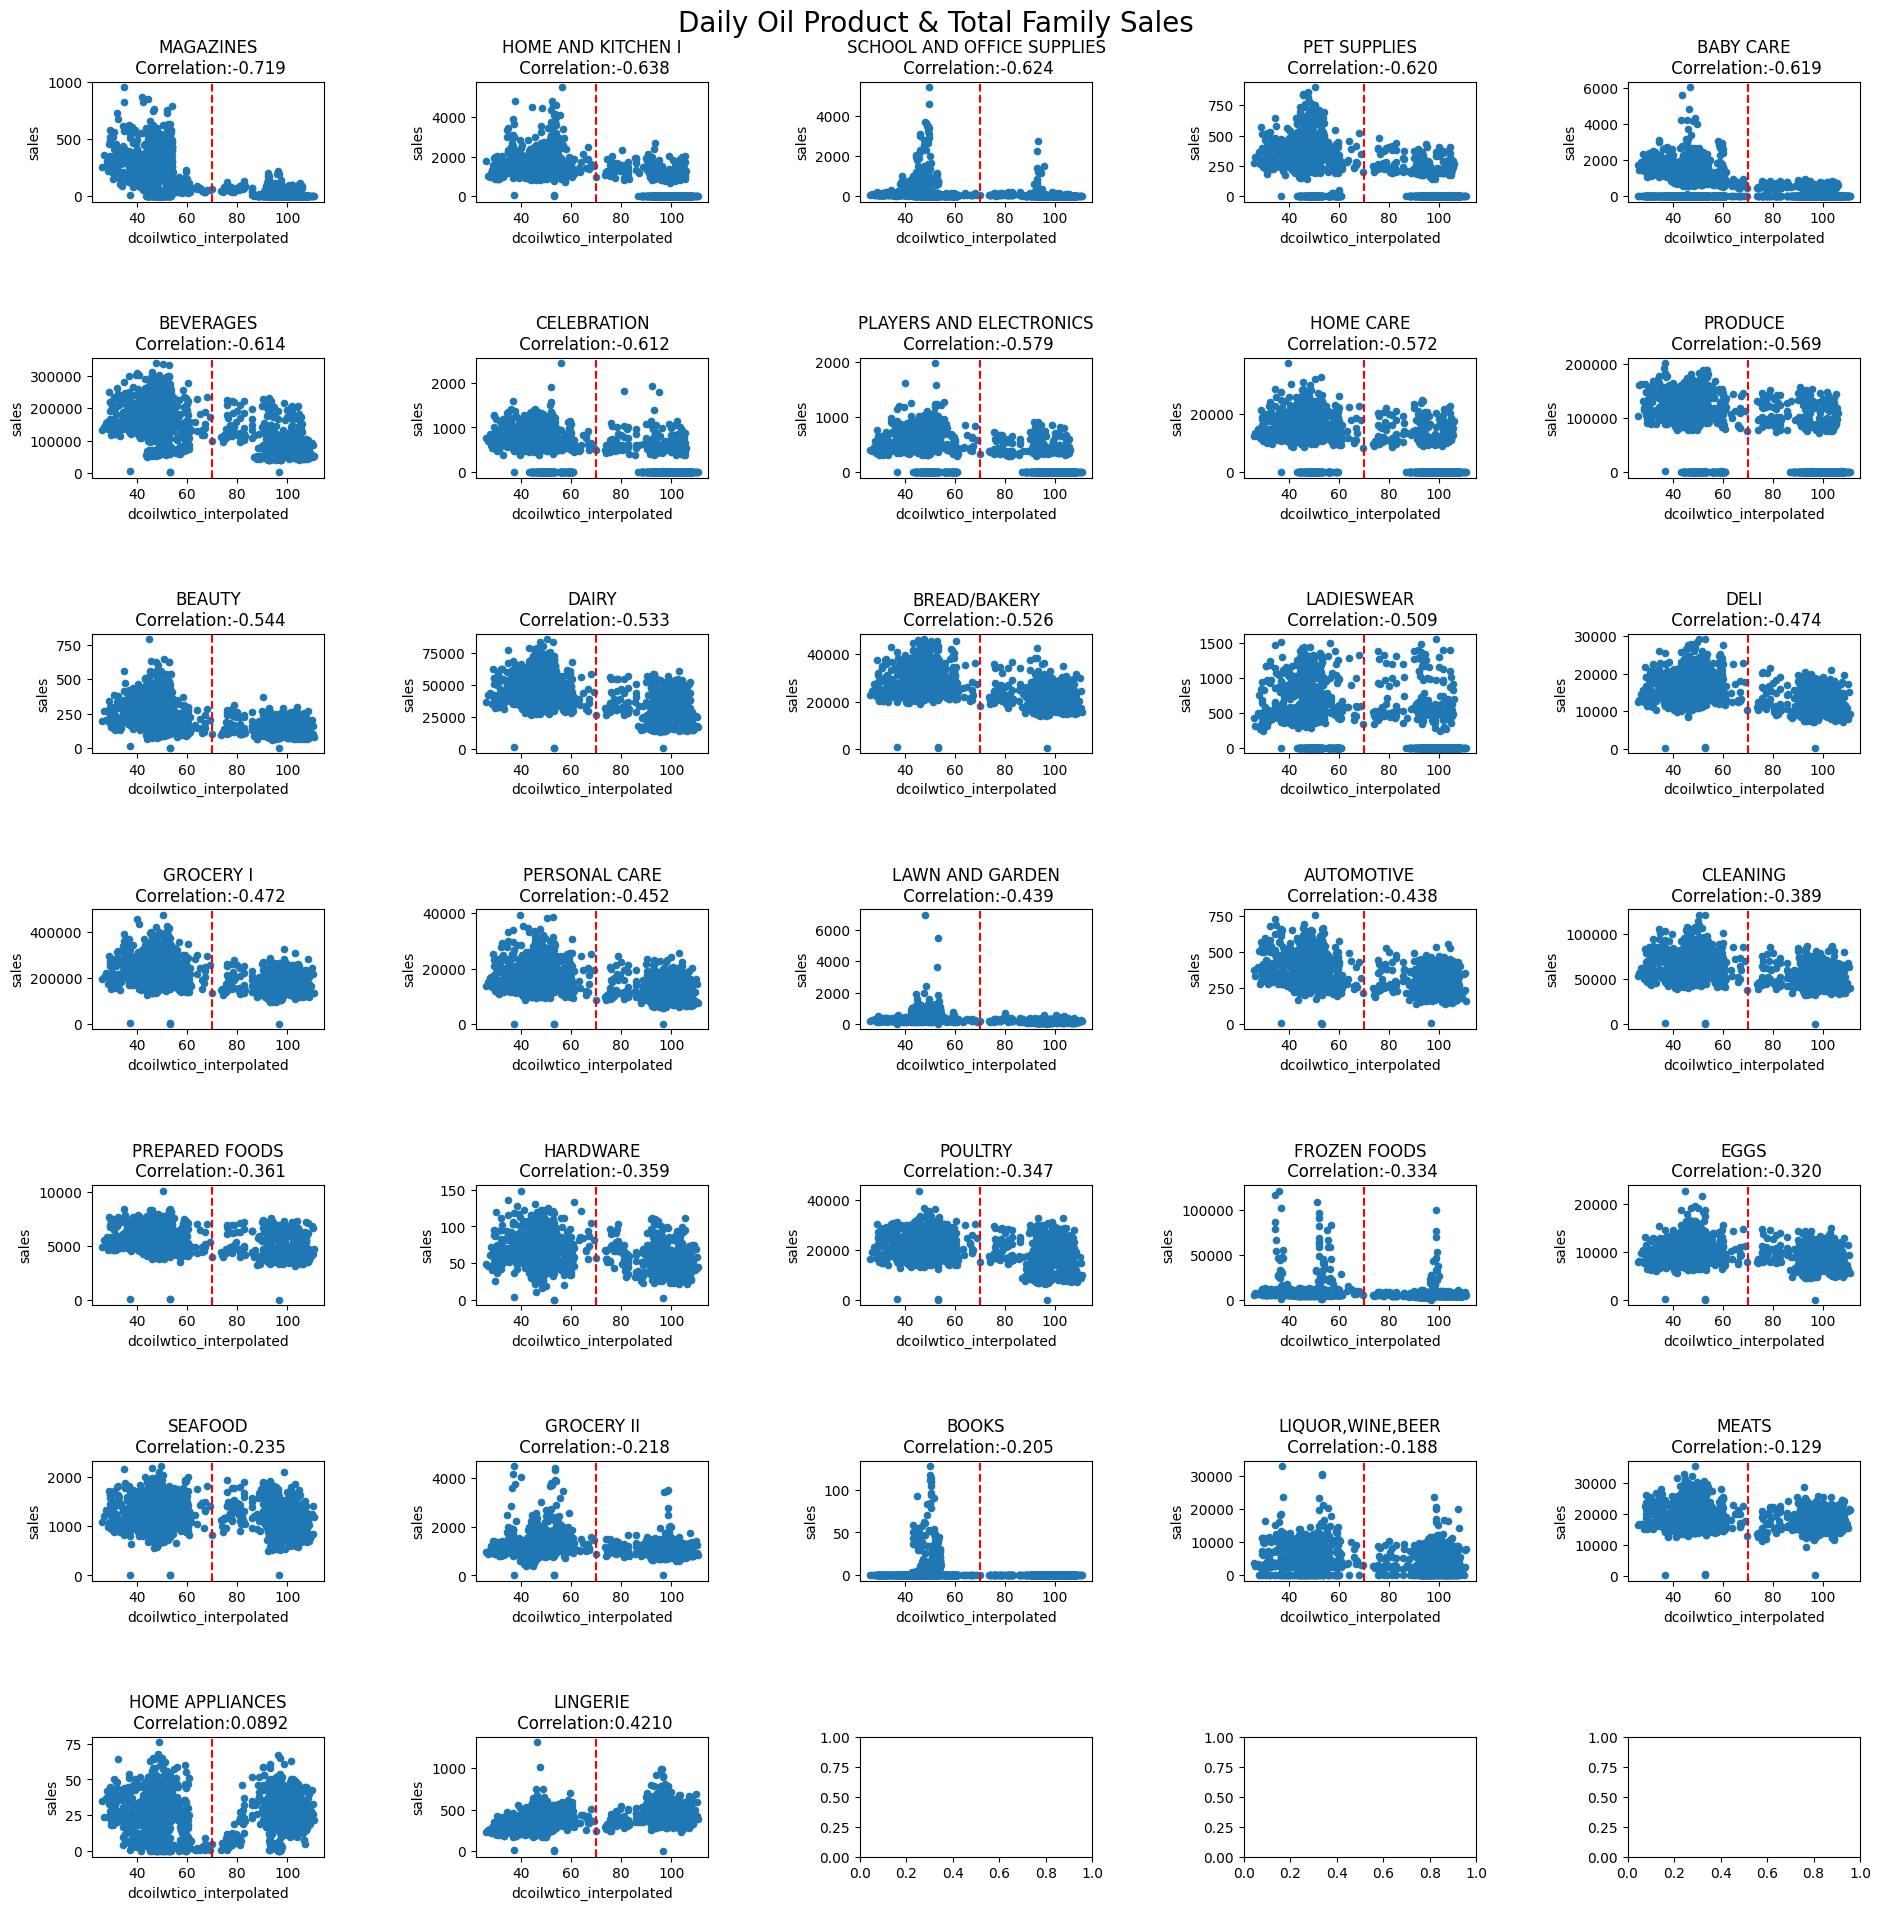

In [8]:
a = pd.merge(training_data.groupby(["date", "family"]).sales.sum().reset_index(), oil.drop("dcoilwtico", axis = 1), how = "left")
c = a.groupby("family").corr("spearman").reset_index()
c = c[c.level_1 == "dcoilwtico_interpolated"][["family", "sales"]].sort_values("sales")

fig, axes = plt.subplots(7, 5, figsize = (20,20))
for i, fam in enumerate(c.family):
    if i < 6:
        a[a.family == fam].plot.scatter(x = "dcoilwtico_interpolated", y = "sales", ax=axes[0, i-1])
        axes[0, i-1].set_title(fam+"\n Correlation:"+str(c[c.family == fam].sales.iloc[0])[:6], fontsize = 12)
        axes[0, i-1].axvline(x=70, color='r', linestyle='--')
    if i >= 6 and i<11:
        a[a.family == fam].plot.scatter(x = "dcoilwtico_interpolated", y = "sales", ax=axes[1, i-6])
        axes[1, i-6].set_title(fam+"\n Correlation:"+str(c[c.family == fam].sales.iloc[0])[:6], fontsize = 12)
        axes[1, i-6].axvline(x=70, color='r', linestyle='--')
    if i >= 11 and i<16:
        a[a.family == fam].plot.scatter(x = "dcoilwtico_interpolated", y = "sales", ax=axes[2, i-11])
        axes[2, i-11].set_title(fam+"\n Correlation:"+str(c[c.family == fam].sales.iloc[0])[:6], fontsize = 12)
        axes[2, i-11].axvline(x=70, color='r', linestyle='--')
    if i >= 16 and i<21:
        a[a.family == fam].plot.scatter(x = "dcoilwtico_interpolated", y = "sales", ax=axes[3, i-16])
        axes[3, i-16].set_title(fam+"\n Correlation:"+str(c[c.family == fam].sales.iloc[0])[:6], fontsize = 12)
        axes[3, i-16].axvline(x=70, color='r', linestyle='--')
    if i >= 21 and i<26:
        a[a.family == fam].plot.scatter(x = "dcoilwtico_interpolated", y = "sales", ax=axes[4, i-21])
        axes[4, i-21].set_title(fam+"\n Correlation:"+str(c[c.family == fam].sales.iloc[0])[:6], fontsize = 12)
        axes[4, i-21].axvline(x=70, color='r', linestyle='--')
    if i >= 26 and i < 31:
        a[a.family == fam].plot.scatter(x = "dcoilwtico_interpolated", y = "sales", ax=axes[5, i-26])
        axes[5, i-26].set_title(fam+"\n Correlation:"+str(c[c.family == fam].sales.iloc[0])[:6], fontsize = 12)
        axes[5, i-26].axvline(x=70, color='r', linestyle='--')
    if i >= 31 :
        a[a.family == fam].plot.scatter(x = "dcoilwtico_interpolated", y = "sales", ax=axes[6, i-31])
        axes[6, i-31].set_title(fam+"\n Correlation:"+str(c[c.family == fam].sales.iloc[0])[:6], fontsize = 12)
        axes[6, i-31].axvline(x=70, color='r', linestyle='--')
        
        
plt.tight_layout(pad=5)
plt.suptitle("Daily Oil Product & Total Family Sales \n", fontsize = 20)
plt.show()

# Observation

Based on the plotted graphs, most of the family products sell more when the oil prices are below 70. Thus, it can be said that there certainly is a correleation between the oil prices and the saleso f the family products.


# Removing irrelevant stores

Upon closer inspection, it seems that some of the stores do not sell some family products. These data points will be removed from the training data and then combined later on in the predictions.

In [ ]:
#What does this do?

# print(train.shape)
# train = train[~((train.store_nbr == 52) & (train.date < "2017-04-20"))]
# train = train[~((train.store_nbr == 22) & (train.date < "2015-10-09"))]
# train = train[~((train.store_nbr == 42) & (train.date < "2015-08-21"))]
# train = train[~((train.store_nbr == 21) & (train.date < "2015-07-24"))]
# train = train[~((train.store_nbr == 29) & (train.date < "2015-03-20"))]
# train = train[~((train.store_nbr == 20) & (train.date < "2015-02-13"))]
# train = train[~((train.store_nbr == 53) & (train.date < "2014-05-29"))]
# train = train[~((train.store_nbr == 36) & (train.date < "2013-05-09"))]
# train.shape

In [11]:
c = training_data.groupby(["store_nbr", "family"]).sales.sum().reset_index().sort_values(["family","store_nbr"])
c = c[c.sales == 0]


print(training_data.shape)
# Anti Join
outer_join = training_data.merge(c[c.sales == 0].drop("sales",axis = 1), how = 'outer', indicator = True)
training_data = outer_join[~(outer_join._merge == 'both')].drop('_merge', axis = 1)
del outer_join
gc.collect()
training_data.shape

(3000888, 6)


(2911636, 6)

In [12]:
zero_prediction = []
for i in range(0,len(c)):
    zero_prediction.append(
        pd.DataFrame({
            "date":pd.date_range("2017-08-16", "2017-08-31").tolist(),
            "store_nbr":c.store_nbr.iloc[i],
            "family":c.family.iloc[i],
            "sales":0
        })
    )
zero_prediction = pd.concat(zero_prediction)
del c
gc.collect()
zero_prediction

,date,store_nbr,family,sales
0,2017-08-16,1,BABY CARE,0
1,2017-08-17,1,BABY CARE,0
2,2017-08-18,1,BABY CARE,0
3,2017-08-19,1,BABY CARE,0
4,2017-08-20,1,BABY CARE,0
...,...,...,...,...
11,2017-08-27,54,LAWN AND GARDEN,0
12,2017-08-28,54,LAWN AND GARDEN,0
13,2017-08-29,54,LAWN AND GARDEN,0
14,2017-08-30,54,LAWN AND GARDEN,0
